# Определение стоимости автомобилей

**Задача:** Обучить модель определять рыночную стоимость автомобиля.

Метрика RMSE

Необходимо учитывать:
- качесто предсказания
- скорость предсказания
- время обучения

**План проекта:**

1. Подготовка данных
   - Обзор данных
   - Предобработка
2. Обучение модели
    - Выборки
    - Кодирование признаков
    - Обучение
3. Анализ моделей
    - Лучшая модель
    - Проверка лучшей модели

## Подготовка данных

In [1]:
# подключаем библиотеки
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt

import time

import warnings
warnings.filterwarnings("ignore")

### Общая информация

In [2]:
# функция для загрузки данных
def load_data(path_1, path_2):

    if not os.path.exists('datasets'):
        os.makedirs('datasets')

    local_path = os.path.join('datasets', path_1)
    if os.path.exists(local_path):
        df = pd.read_csv(local_path)
        print('Файл загружен локально')
    else:
        try:
            df = pd.read_csv(path_2)
            print('Файл загружен из сети')
        except:
            print('Не удалось загрузить файл')
    return df

In [3]:
df = load_data('autos.csv', 'https://datasets/autos.csv')

Файл загружен из сети


In [4]:
# откроем файл
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Вывод:** В данных есть пропуски, также, что подозрительно, есть нули в Power и RegistrationMonth. Совершенно пустой столбец с количество картинок. Не верный тип у дат. Есть аномалии в Price, Power и в RegistrationYear.

### Предобработка

Что будем делать:
* Изменим названия столбцов на змеиный регистр для удобства
* Изучим и заполним пропуски
* Проверим данные на наличие явных и неявных дублей
* Изучим распределение числовых данных. Избавимся от аномалий

In [7]:
# названия столбцов
df.columns = df.columns.str.lower()
df = df.rename(columns={
    'registrationyear' : 'reg_year', 
    'registrationmonth' : 'reg_month', 
    'postalcode' : 'postal_code', 
    'datecrawled' : 'date_crawled', 
    'datecreated' : 'date_created', 
    'lastseen' : 'last_seen', 
    'vehicletype' : 'vehicle_type', 
    'fueltype' : 'fuel_type'})

#### Пропуски

Посмотрим на процент пропусков в данных и найдем им замену.

In [8]:
df.isna().sum()

date_crawled            0
price                   0
vehicle_type        37490
reg_year                0
gearbox             19833
power                   0
model               19705
kilometer               0
reg_month               0
fuel_type           32895
brand                   0
repaired            71154
date_created            0
numberofpictures        0
postal_code             0
last_seen               0
dtype: int64

In [9]:
def pass_value_barh(df):
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=(10,6), legend=False, fontsize=16, ax = ax)
            .set_title('Пропущенные значения, %' + "\n", fontsize=22, color='SteelBlue')
        );
        plt.grid(visible=True, color='grey', linestyle='--', linewidth=0.5, alpha=0.8)
        plt.xlim(0, 100)
    
        for i in ax.patches:
            plt.text(i.get_width()+0.2, i.get_y()+0.1,
                     str(round((i.get_width()), 1)),
                     fontsize=14, 
                     color='black')
    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции')

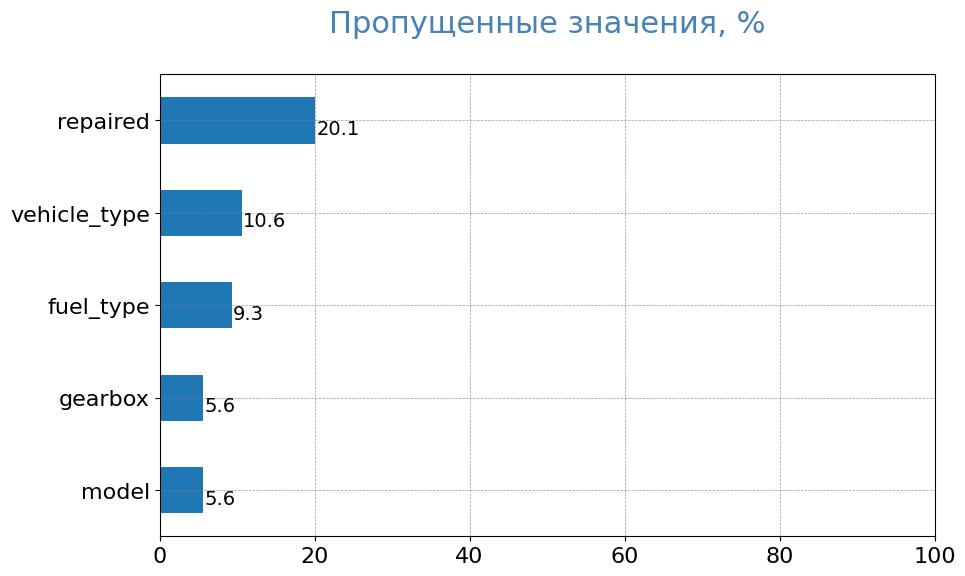

In [10]:
pass_value_barh(df)

Заменим пропуски в model заглушкой, так как сложно узнать какой модели был автомобиль, по имеющимся данным. 

In [11]:
df['model'].value_counts()
df['model'].unique()

# поставим заглушку для пропущенных значений
df['model'] = df['model'].fillna('unknown')
df['model'].isna().sum()

0

In [12]:
df['vehicle_type'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In [13]:
df['fuel_type'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [14]:
df['gearbox'].value_counts()

manual    268251
auto       66285
Name: gearbox, dtype: int64

Для заполнения пропусков в столбцах с типом кузова, топлива и коробки передач сгруппируем данные по моделям и бренду, затем найдем наиболее часто встречающееся значение.

In [15]:
df['vehicle_type'] = df['vehicle_type'].fillna(
    df.groupby(['model', 'brand'])['vehicle_type']
    .transform(lambda x: x.value_counts().idxmax()))

df['fuel_type'] = df['fuel_type'].fillna(
    df.groupby(['model', 'brand'])['fuel_type']
    .transform(lambda x: x.value_counts().idxmax()))

df['gearbox'] = df['gearbox'].fillna(
    df.groupby(['model', 'brand'])['gearbox']
    .transform(lambda x: x.value_counts().idxmax()))

In [16]:
df['repaired'].value_counts()

no     247161
yes     36054
Name: repaired, dtype: int64

Нельзя узнать был ли автомобиль в ремонте по имеющимся данным. Ставим заглушку.

In [17]:
df['repaired'] = df['repaired'].fillna('unknown')
df.isna().sum()

date_crawled        0
price               0
vehicle_type        0
reg_year            0
gearbox             0
power               0
model               0
kilometer           0
reg_month           0
fuel_type           0
brand               0
repaired            0
date_created        0
numberofpictures    0
postal_code         0
last_seen           0
dtype: int64

#### Дубликаты

Посчитаем количество явных дубликатов. И найдем не явные дубликаты по столбцам model. Устраним их.

In [18]:
df.duplicated().sum()

4

In [19]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

In [20]:
sorted(df['model'].unique())

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

In [21]:
df['model'] = df['model'].replace('rangerover', 'range_rover')
sorted(df['model'].unique())

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

Избавимся от ненужных столбцов NumberOfPictures, DateCrawled, DateCreated, LastSeen, PostalCode, так как они неинформативны и никак не повлияют на качество модели

In [22]:
# удалим лишние столбцы
data_for_drop = ['numberofpictures', 'date_crawled', 'date_created', 'last_seen', 'postal_code', 'reg_month']
df = df.drop(data_for_drop, axis=1)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         354365 non-null  int64 
 1   vehicle_type  354365 non-null  object
 2   reg_year      354365 non-null  int64 
 3   gearbox       354365 non-null  object
 4   power         354365 non-null  int64 
 5   model         354365 non-null  object
 6   kilometer     354365 non-null  int64 
 7   fuel_type     354365 non-null  object
 8   brand         354365 non-null  object
 9   repaired      354365 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


#### Аномалии

Построим графики распределений для числовых данных. 

In [24]:
# сохраним старый датафрейм для сравнения
old_df = df.copy()

In [25]:
df.describe()

,price,reg_year,power,kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [26]:
# квантили
(
    df[['price', 'reg_year', 'power', 'kilometer']]
    .quantile([0.0012, 0.01, .5, .99, .9988])
    .style.format("{:,.2f}")
)

,price,reg_year,power,kilometer
0.0012,0.00,"1,960.00",0.00,"5,000.00"
0.01,0.00,"1,980.00",0.00,"5,000.00"
0.5,"2,700.00","2,003.00",105.00,"150,000.00"
0.99,"18,800.00","2,018.00",300.00,"150,000.00"
0.9988,"19,999.00","2,018.00",520.00,"150,000.00"


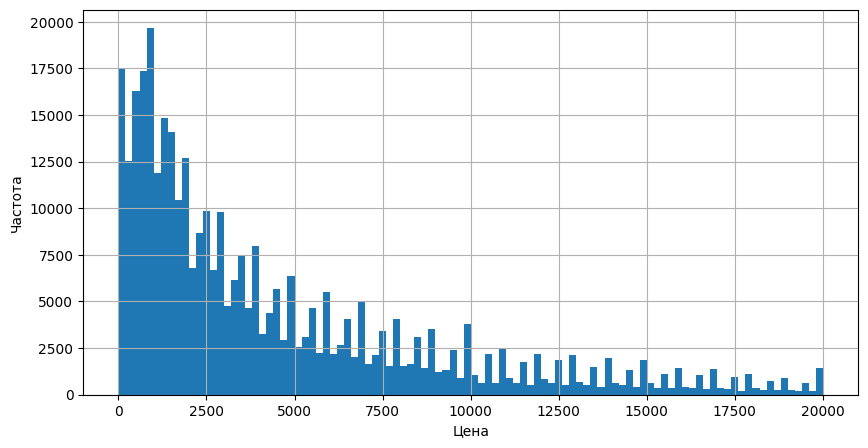

In [27]:
df['price'].hist(bins = 100, figsize = (10,5));
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

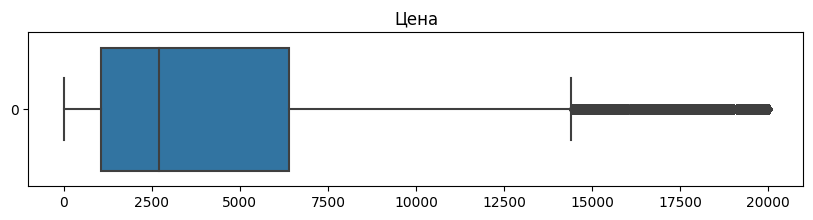

In [28]:
plt.figure(figsize=(10,2))
sns.boxplot(data=df.price, orient='h').set(title='Цена')
plt.show()

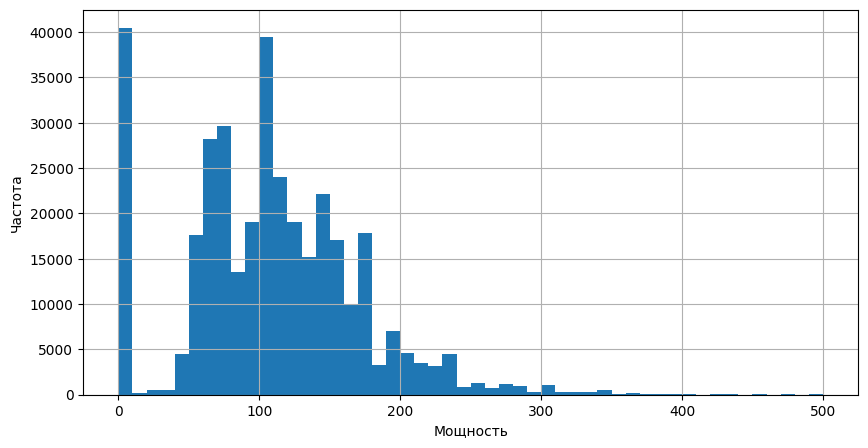

In [29]:
df['power'].hist(bins = 50, figsize = (10,5), range=(0, 500));
plt.xlabel('Мощность')
plt.ylabel('Частота')
plt.show()

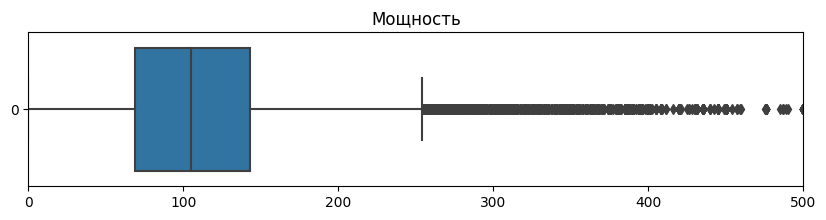

In [30]:
plt.figure(figsize=(10,2))
sns.boxplot(data=df.power, orient='h').set(title='Мощность')
plt.xlim(0, 500)
plt.show()

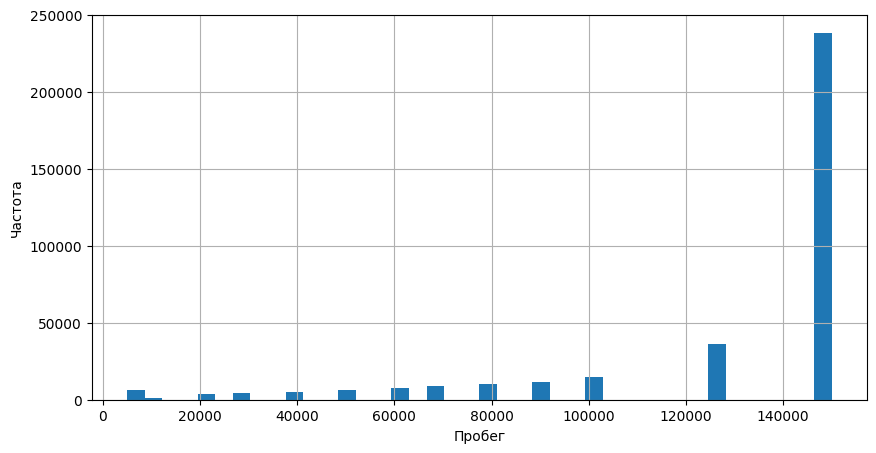

In [31]:
df['kilometer'].hist(bins = 40, figsize = (10,5));
plt.xlabel('Пробег')
plt.ylabel('Частота')
plt.show()

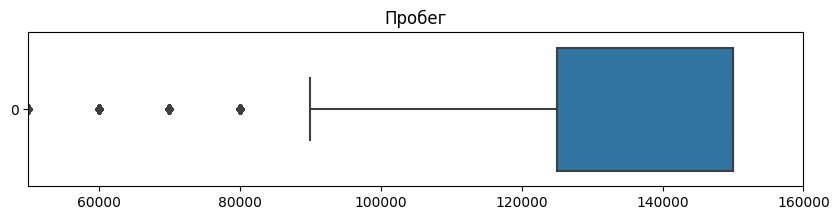

In [32]:
plt.figure(figsize=(10,2))
sns.boxplot(data=df.kilometer, orient='h').set(title='Пробег')
plt.xlim(50000, 160000)
plt.show()

In [33]:
df['kilometer'].value_counts()

150000    238207
125000     36453
100000     14882
90000      11567
80000      10047
70000       8593
60000       7444
5000        6397
50000       6232
40000       4911
30000       4436
20000       3974
10000       1222
Name: kilometer, dtype: int64

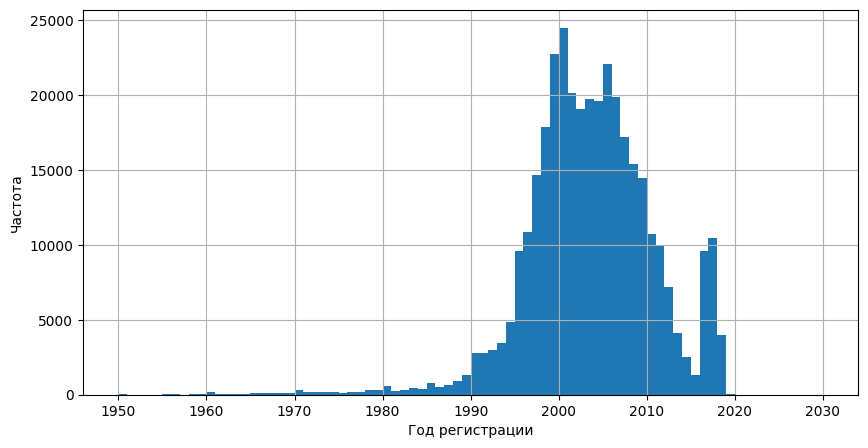

In [34]:
df['reg_year'].hist(bins = 80, figsize = (10,5), range=(1950, 2030));
plt.xlabel('Год регистрации')
plt.ylabel('Частота')
plt.show()

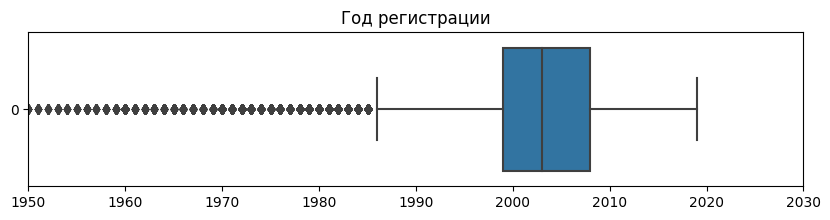

In [35]:
plt.figure(figsize=(10,2))
sns.boxplot(data=df.reg_year, orient='h').set(title='Год регистрации')
plt.xlim(1950, 2030)
plt.show()

Отсекаем аномальные значения. 
* В столбце price не должно быть нулей, потому что это целевой признак, они повлияют на результат. 
* Мощность автомобиля не может быть нулевой, а самая максимальная мощность легкового автомобиля еще не превышала 3000 л.с. 
* Большая часть автомобилей имеет пробег в 150000 км, это значит, что автомобилю должно быть примерно 10 лет. Допустим, что авто стояло какое-то время, возможно несколько лет, поэтому есть авто 2000 года выпуска и даже раньше. Но, чтобы не брать во внимание совсем уж старые машины, года ограничим по 1985 году и до настоящего момента. 

In [36]:
df = df.query('0 < price')
df = df.query('20 < power < 700')
df = df.query('1985 < reg_year < 2017')

In [37]:
print('Процент удаленных данных: {:,.2%}'
      .format((len(old_df) - len(df)) / len(old_df)))

Процент удаленных данных: 17.55%


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292177 entries, 1 to 354364
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         292177 non-null  int64 
 1   vehicle_type  292177 non-null  object
 2   reg_year      292177 non-null  int64 
 3   gearbox       292177 non-null  object
 4   power         292177 non-null  int64 
 5   model         292177 non-null  object
 6   kilometer     292177 non-null  int64 
 7   fuel_type     292177 non-null  object
 8   brand         292177 non-null  object
 9   repaired      292177 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.5+ MB


In [39]:
# корреляция
df.corr()

,price,reg_year,power,kilometer
price,1.000000,0.597117,0.511731,-0.391567
reg_year,0.597117,1.000000,0.134898,-0.393205
power,0.511731,0.134898,1.000000,0.096858
kilometer,-0.391567,-0.393205,0.096858,1.000000


Есть положительная корреляция между ценой и мощностью, ценой и годом регистрации автомобиля и отрицательная корреляция между ценой и пробегом.

**Вывод:** Данный были очищены от пропусков, дубликатов и аномалий. Пришлось удалить примерно 17.5% данных. Также удалены неинформативные признаки. 

## Обучение моделей

* Разделим датасет на обучающую и тестовую выборки
* Закодируем категориальные данные
* Обучим модели 
* Поэксперементируем с гиперпараметрами
* Найдем RMSE моделей

In [40]:
# функция для нахождения RSME
def rmse(target, pred):
    return sqrt(mean_squared_error(target, pred))

In [41]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

### Выборки

In [42]:
# выделим признаки
features = df.drop('price', axis=1)
target = df['price']

In [43]:
# разобьем на две выборки
train_features, test_features, train_target, test_target = train_test_split(
    features, target, test_size=0.25, random_state=12345)

print('Размер обучающей выборки:', train_target.shape, train_features.shape)
print('Размер тестовой выборки:', test_target.shape, test_features.shape)

Размер обучающей выборки: (219132,) (219132, 9)
Размер тестовой выборки: (73045,) (73045, 9)


In [44]:
train_features.head()

,vehicle_type,reg_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
59342,sedan,2011,manual,235,golf,150000,petrol,volkswagen,no
232971,small,2000,manual,60,ibiza,150000,petrol,seat,yes
252224,wagon,2016,manual,150,passat,150000,gasoline,volkswagen,unknown
331840,sedan,2006,manual,102,golf,150000,petrol,volkswagen,unknown
10017,sedan,1995,manual,125,a4,150000,petrol,audi,no


### Кодирование категориальных данных

In [45]:
train_features_ec = train_features.copy()
test_features_ec = test_features.copy()

# кодируем
cat_col = ['vehicle_type', 
           'gearbox', 
           'model', 
           'fuel_type', 
           'brand', 
           'repaired']

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(train_features_ec[cat_col])

train_features_ec[cat_col] = encoder.transform(train_features_ec[cat_col])
test_features_ec[cat_col] = encoder.transform(test_features_ec[cat_col])

train_features_ec.head()

,vehicle_type,reg_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
59342,4.0,2011,1.0,235,116.0,150000,6.0,38.0,0.0
232971,5.0,2000,1.0,60,120.0,150000,6.0,30.0,2.0
252224,7.0,2016,1.0,150,170.0,150000,2.0,38.0,1.0
331840,4.0,2006,1.0,102,116.0,150000,6.0,38.0,1.0
10017,4.0,1995,1.0,125,29.0,150000,6.0,1.0,0.0


In [46]:
# масштабируем
pd.options.mode.chained_assignment = None
train_features_ec_sc = train_features_ec.copy()
test_features_ec_sc = test_features_ec.copy()

scaler = StandardScaler()
scaler.fit(train_features_ec_sc)

train_features_ec_sc = scaler.transform(train_features_ec_sc)
test_features_ec_sc = scaler.transform(test_features_ec_sc)

train_features_ec_sc = pd.DataFrame(train_features_ec_sc)
test_features_ec_sc = pd.DataFrame(test_features_ec_sc)

train_features_ec_sc.head()

,0,1,2,3,4,5,6,7,8
0,-0.133236,1.372827,0.500617,2.120185,0.065454,0.584807,0.689584,1.294395,-0.522840
1,0.341972,-0.557935,0.500617,-1.135100,0.120813,0.584807,0.689584,0.697177,2.568327
2,1.292389,2.250446,0.500617,0.539046,0.812793,0.584807,-1.469778,1.294395,1.022743
3,-0.133236,0.495208,0.500617,-0.353832,0.065454,0.584807,0.689584,1.294395,1.022743
4,-0.133236,-1.435555,0.500617,0.074006,-1.138591,0.584807,0.689584,-1.467739,-0.522840


### LightGBM

In [47]:
%%time
lgb_params = {#'n_estimators': range(50, 200, 50),
              #'max_depth': range(2, 12, 2),
              'num_leaves':[100, 150, 200], 
              'learning_rate':[0.1, 0.3, 0.5]}

lgb_model = LGBMRegressor()
lgb_grid_search = GridSearchCV(lgb_model, lgb_params, cv=5, scoring=rmse_scorer)
start = time.time()
lgb_grid_search.fit(train_features_ec_sc, train_target)
end = time.time()
lgb_time_fit = round((end - start), 3) 

lgb_score = -lgb_grid_search.best_score_
print('Лучшее значение RMSE : {} при : {}'
      .format(lgb_score, lgb_grid_search.best_params_))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 175305, number of used features: 9
[LightGBM] [Info] Start training from score 4825.894236
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 608
[LightGBM] [Info] Number of data points in the train set: 175305, number of used features: 9
[LightGBM] [Info] Start training from score 4827.725655
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [I

In [48]:
%%time
# время предсказания
start = time.time()
lgb_pred = lgb_grid_search.best_estimator_.predict(test_features_ec_sc)
end = time.time()
lgb_time_pred = round((end - start), 3) 

CPU times: total: 688 ms
Wall time: 175 ms


### CatBoost

In [49]:
%%time
cb_params = {'depth': [4, 6, 10],
             'learning_rate': [0.03, 0.1]
            }

cb_model = CatBoostRegressor()
cb_grid_search = GridSearchCV(cb_model, cb_params, cv=5, scoring=rmse_scorer)
start = time.time()
cb_grid_search.fit(train_features_ec_sc, train_target)
end = time.time()
cb_time_fit = round((end - start), 3) 

cb_score = -cb_grid_search.best_score_
print('Лучшее значение RMSE : {} при : {}'
      .format(cb_score, cb_grid_search.best_params_))

0:	learn: 4514.8922052	total: 180ms	remaining: 2m 59s
1:	learn: 4433.8027286	total: 193ms	remaining: 1m 36s
2:	learn: 4353.2979336	total: 206ms	remaining: 1m 8s
3:	learn: 4276.1660129	total: 220ms	remaining: 54.8s
4:	learn: 4204.0425671	total: 233ms	remaining: 46.4s
5:	learn: 4131.0061441	total: 246ms	remaining: 40.7s
6:	learn: 4061.1966629	total: 258ms	remaining: 36.6s
7:	learn: 3993.1894850	total: 270ms	remaining: 33.5s
8:	learn: 3928.8301525	total: 282ms	remaining: 31.1s
9:	learn: 3868.4530583	total: 294ms	remaining: 29.1s
10:	learn: 3808.1813429	total: 306ms	remaining: 27.5s
11:	learn: 3751.3636407	total: 318ms	remaining: 26.2s
12:	learn: 3693.4369762	total: 330ms	remaining: 25.1s
13:	learn: 3638.2855578	total: 342ms	remaining: 24.1s
14:	learn: 3586.1074508	total: 354ms	remaining: 23.3s
15:	learn: 3536.4886485	total: 367ms	remaining: 22.6s
16:	learn: 3485.6525359	total: 378ms	remaining: 21.9s
17:	learn: 3438.3753125	total: 393ms	remaining: 21.4s
18:	learn: 3393.2647957	total: 409ms

In [50]:
%%time
# время предсказания
start = time.time()
cb_pred = cb_grid_search.best_estimator_.predict(test_features_ec_sc)
end = time.time()
cb_time_pred = round((end - start), 3) 

CPU times: total: 1.94 s
Wall time: 401 ms


### Decision Tree

In [51]:
%%time
dt_params = {'max_depth': range(2, 7)}

dt_model = DecisionTreeRegressor()
dt_grid_search = GridSearchCV(dt_model, dt_params, cv=5, scoring=rmse_scorer)
start = time.time()
dt_grid_search.fit(train_features_ec_sc, train_target)
end = time.time()
dt_time_fit = round((end - start), 3) 

dt_score = -dt_grid_search.best_score_
print('Лучшее значение RMSE : {} при : {}'
      .format(dt_score, dt_grid_search.best_params_))

Лучшее значение RMSE : 2203.698203219473 при : {'max_depth': 6}
CPU times: total: 4.62 s
Wall time: 4.99 s


In [53]:
%%time
# время предсказания
start = time.time()
dt_pred = dt_grid_search.best_estimator_.predict(test_features_ec_sc)
end = time.time()
dt_time_pred = round((end - start), 3) 

CPU times: total: 15.6 ms
Wall time: 35.9 ms


### Random Forest

In [54]:
%%time
rf_params = {'max_depth' : [6, 12], 
             'n_estimators': [100, 150]
            }

rf_model = RandomForestRegressor()
rf_grid_search = GridSearchCV(rf_model, rf_params, cv=5, scoring=rmse_scorer)
start = time.time()
rf_grid_search.fit(train_features_ec_sc, train_target)
end = time.time()
rf_time_fit = round((end - start), 3) 

rf_score = -rf_grid_search.best_score_
print('Лучшее значение RMSE : {} при : {}'
      .format(rf_score, rf_grid_search.best_params_))

Лучшее значение RMSE : 1681.792833044119 при : {'max_depth': 12, 'n_estimators': 150}
CPU times: total: 9min 40s
Wall time: 9min 41s


In [55]:
%%time
# время предсказания
start = time.time()
rf_pred = rf_grid_search.best_estimator_.predict(test_features_ec_sc)
end = time.time()
rf_time_pred = round((end - start), 3) 

CPU times: total: 1.34 s
Wall time: 1.35 s


**Вывод:** Были обучены четыре модели LightGBM, CatBoost, Decision Tree, Random Forest. Подобрали для каждой гипперпараметры и вычислили RMSE.

## Анализ моделей

* Сравним время обучения, время предсказания и качество моделей 
* Выберем лучшую модель
* Проверим качество лучшей модели на тестовой выборке

### Лучшая модель

In [56]:
# сравним модели
final_result = pd.DataFrame({'Модель':['LightGBM', 'CatBoostRegressor', 'Decision Tree', 'Random Forest'],
                             'RMSE':[lgb_score, cb_score, dt_score, rf_score],
                             'Время обучения (сек)':[lgb_time_fit, cb_time_fit, dt_time_fit, rf_time_fit],
                             'Время предсказания (сек)':[lgb_time_pred, cb_time_pred, dt_time_pred, rf_time_pred]
                            })

final_result.sort_values('RMSE')

,Модель,RMSE,Время обучения (сек),Время предсказания (сек)
1,CatBoostRegressor,1479.533771,778.150,0.401
0,LightGBM,1496.687680,40.395,0.175
3,Random Forest,1681.792833,581.566,1.349
2,Decision Tree,2203.698203,4.972,0.035


Лучшие показатели RMSE и время обучения у модели LightGBM. 

### Проверка лучшей модели

In [57]:
%%time
test_pred = lgb_grid_search.best_estimator_.predict(test_features_ec_sc)
test_rmse = rmse(test_target, test_pred)
print('RMSE тестовой выборки', test_rmse)

RMSE тестовой выборки 1493.220038788401
CPU times: total: 672 ms
Wall time: 225 ms


## Общий вывод

* Данные исследованы, устранены пропуски, дубликаты и аномалии. Удалено примерно 20% данных.
* Данные были разделены на тренировочную и тестовую выборки. Категориальные данные закодированы методом порядкого кодирования, после чего признаки были масштабированы.
* Обучены модели градиентного бустинга - LightGBM и CatBoost, а также модели решающего дерева и случайного леса. Подобраны лучшие гипперпараметры и получена метрика RMSE.
* Сравнили качество обученных моделей, время предсказания и время обучения.
* Проверили лучшую модель на тестовой выборке.

Лучшей моделью выбрана LightGBM	с показателями 
* RMSE 1495, 
* время обучения 39 секунд, 
* время предсказания 163 миллисекунды